## Investigate the relationship between relief award type and amount over time

## Goals

In this case study, we will be processing foreign assistance data using basic functions from the `pandas` python module and doing some basic data visualizations to better understand how relief aid is disbursed in Venezuela. 

## Introduction

**Context.** The U.S. manages foreign assistance programs in more than 100 countries around the world through the efforts of over 20 different U.S. government agencies. Foreign assistance is aid that is given by the United States to other countries to support global peace, security, and development efforts, and to provide humanitarian relief during times of crisis. These investments further America's foreign policy interests on issues ranging from expanding free markets, combating extremism, ensuring stable democracies, and addressing the root causes of poverty.

To learn more about these efforts, you can visit the website https://foreignassistance.gov

The question of whether or not foreign aid has the intended effects is unclear - there is little evidence of a significant positive effect of aid on the long-term development of countries that receive this aid. 

**Objective.** Venezuela is a country in South America which has experienced political turmoil in the last decade with an increasingly authoritarian leader and significant struggles with hyperinflation, shortages of basic goods, widespread unemployment, poverty, disease, high child mortality, malnutrition, crime, and corruption. 

The United States has provided hundreds of millions of dollars in life-saving aid and for critical social services - including shelter, health assistance, protection from violence and exploitation, and access to work and education opportunities for Venezuelans both at home and htose living in other countries in the region. In this exercise, we will work through descriptive analysis to understand the relationship between aid amount and various attributes of the award in Venezuela.


**Analytical Task.** We will be processing data in CSV format from foreignassistance.gov website, which aggregates data on individual assistance awards that are distributed from over 20 U.S. government agencies on a quarterly basis and makes it available under creative commons licenses for people like us to do analyses.

In this exercise, we will: 

(1) pre-process the data to convert it into a format that we can use for subsequent analyses;

(2) Use simple plotting to explore the relationships between aid amount and type

In [7]:
# import modules
import pandas as pd
import numpy as np 
from sklearn import preprocessing
import os
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 

In [13]:
# import the data
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
file_id = '1QeIrBeSh37mXFAlSPkfWq9RrnTvQaS8b'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('wk2_Venezuela.csv')  
#print('Downloaded content "{}"'.format(downloaded.GetContentString()))

ModuleNotFoundError: No module named 'pydrive'

In [11]:
aid_df = pd.DataFrame(pd.read_csv('wk2_Venezuela.csv')) # load the aid data set

FileNotFoundError: [Errno 2] No such file or directory: 'wk2_Venezuela.csv'


Start by examing the data that is stored in this file. We can do this by printing out the column names along side the column type.

In [4]:
aid_df.dtypes

Funding Agency                                        object
Funding Agency - Office                               object
Managing Agency                                       object
Managing Agency - Office                              object
Implementing Partner                                  object
Implementing Partner - Type                           object
Implementing Partner - Country                        object
Implementing Partner - DUNS Number                    object
Award - Interagency Transfer Status                   object
Award - Identifier                                    object
Award - Title                                         object
Award - Description                                   object
Award - Benefitting Location                          object
Award - Status                                        object
Award - Total Estimated Value                        float64
Award - Signing Date                                  object
Award - Start Date      

### Question for the class:

- What do these data types represent?


There are **39** features collected for each award. There are several related to the Funding and managing agency, the implementing partner, the award itself, the transaction, and the treasury account.

To simplify our analysis, we're going to reduce the number of columns. We'll do this by creating a new list containing the names of columns we want to keep, which we name 'cols', then subset the aid_df so that it only includes the columns in the list. 

In [5]:
cols = ['Funding Agency',
        'Award - Interagency Transfer Status',
        'Transaction - DAC Purpose Code Name',
        'Treasury Account - Title',
        'Award - Title',
        'Award - Description',
        'Award - Benefitting Location',
        'Award - Status',
        'Award - Total Estimated Value',
        'Award - Start Date',
        'Award - End Date',
        'Transaction - Description',
        'Transaction - Type',
        'Transaction - Aid Type',
        'Transaction - U.S. Foreign Assistance Sector Name',
        'Transaction - U.S. Foreign Assistance Category']

aid_df = aid_df[cols]

To preview this data set we can use the pandas 'head' command. We can specify the number of rows to output inside the parentheses, but if you leave this empty it will default to the first 5 rows.

In [6]:
aid_df.head()

,Funding Agency,Award - Interagency Transfer Status,Transaction - DAC Purpose Code Name,Treasury Account - Title,Award - Title,Award - Description,Award - Benefitting Location,Award - Status,Award - Total Estimated Value,Award - Start Date,Award - End Date,Transaction - Description,Transaction - Type,Transaction - Aid Type,Transaction - U.S. Foreign Assistance Sector Name,Transaction - U.S. Foreign Assistance Category
0,U.S. Agency for International Development,Direct Appropriation,Democratic participation and civil society,"Development Assistance, Agency for Internation...",Assisting Independent News Supply,This USAID program is part of a larger U.S.~go...,Venezuela,Implementation,19906259.0,4/1/14,3/31/24,Disbursement,Disbursement,Project-type interventions,Civil Society,"Democracy, Human Rights, and Governance"
1,U.S. Agency for International Development,Direct Appropriation,Administrative costs (non-sector allocable),"Development Assistance, Agency for Internation...","USAID Equipment, Lands, and Structures",Administrative costs and operating expenses of...,Venezuela,Finalisation,0.0,10/1/17,9/30/18,Commitment,Commitment,Administrative costs not included elsewhere,Direct Administrative Costs,Program Management
2,U.S. Agency for International Development,Direct Appropriation,Administrative costs (non-sector allocable),"Economic Support Fund, Funds Appropriated to t...","USAID Miscellaneous Goods, Services, and Opera...",Administrative costs and operating expenses of...,Venezuela,Finalisation,0.0,10/1/13,9/30/14,Disbursement,Disbursement,Administrative costs not included elsewhere,Direct Administrative Costs,Program Management
3,U.S. Agency for International Development,Direct Appropriation,Administrative costs (non-sector allocable),"Development Assistance, Agency for Internation...",Administration and Oversight,Supports the following illustrative program-fu...,Venezuela,Implementation,733742.0,10/1/19,9/30/20,Disbursement,Disbursement,Administrative costs not included elsewhere,Direct Administrative Costs,Program Management
4,U.S. Agency for International Development,Direct Appropriation,Democratic participation and civil society,"Economic Support Fund, Funds Appropriated to t...",National Assembly,USAID is building the capacity of the democrat...,Venezuela,Finalisation,8400000.0,9/30/16,9/30/20,Disbursement,Disbursement,Project-type interventions,Good Governance,"Democracy, Human Rights, and Governance"


Let's start by focusing on the **award amount**.

The award amount is reported in the column labeled 'Award - Total Estimated Value'. Let's look at the distribution of those values.

We do this using pandas' 'describe' command which prints out the sample size, mean, standard deviation, range, and percentiles for the data. 

In [7]:
aid_df['Award - Total Estimated Value'].describe()

count    1.726000e+03
mean     3.248593e+06
std      1.260573e+07
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      3.883955e+06
max      3.159622e+08
Name: Award - Total Estimated Value, dtype: float64

In [8]:
for i in range(0,aid_df['Award - Total Estimated Value'].describe().shape[0]):
  if i == 0:
    print(aid_df['Award - Total Estimated Value'].describe().round().index[i] + 
        ":  "+
        "{:,}".format(aid_df['Award - Total Estimated Value'].describe().round()[i]))
  else:
    print(aid_df['Award - Total Estimated Value'].describe().round().index[i] + 
          ":  $ "+
          "{:,}".format(aid_df['Award - Total Estimated Value'].describe().round()[i]))

count:  1,726.0
mean:  $ 3,248,593.0
std:  $ 12,605,732.0
min:  $ 0.0
25%:  $ 0.0
50%:  $ 0.0
75%:  $ 3,883,955.0
max:  $ 315,962,159.0


### Discussion Questions:

- How do we interpret these values? 
- What do they tell us about the distribution of the aid awards?

Let's examine the other data in the table - including the **award type**.

I'm curious what the set of qualitative features includes, but I don't want to include the columns encoding date or award description since it's a lot of text; we can examine that separately. 

In [9]:
for col in aid_df.drop(columns=['Award - Total Estimated Value', 'Award - Start Date','Award - End Date', 'Award - Description']):
  print('\n',col,':\n')
  for row in aid_df[col].unique():
    print('\t',row)


 Funding Agency :

	 U.S. Agency for International Development
	 U.S. Department of State
	 Inter-American Foundation
	 U.S. Department of the Interior
	 U.S. Department of Agriculture

 Award - Interagency Transfer Status :

	 Direct Appropriation
	 nan
	 632b
	 632a
	 Direct Apportionment

 Transaction - DAC Purpose Code Name :

	 Democratic participation and civil society
	 Administrative costs (non-sector allocable)
	 Relief co-ordination and support services
	 Elections
	 Media and free flow of information
	 Human rights
	 Material relief assistance and services
	 Emergency food assistance
	 Agricultural policy and administrative management
	 Civilian peace-building, conflict prevention and resolution
	 Multi-hazard response preparedness
	 Public finance management (PFM)
	 Multisector aid
	 Public sector policy and administrative management
	 Primary education
	 Environmental policy and administrative management
	 COVID-19 control
	 Reproductive health care
	 Agricultural develop

Looking at the aid description might help us to interpret all of this data better. I'm randomingly selecting the first couple of text award descriptions - remember that indices in python begin at **0** not **1**.

In [10]:
aid_df['Award - Description'][0]

'This USAID program is part of a larger U.S.~government effort to promote democratic representative governance in Venezuela and similar to democracy and governance support in various countries around the world. The program responds to increasing government control over news and information available on broadcast media, seeking to increase the availability of independent news to lower-income Venezuelans who do not have reliable, efficient access to the internet. The program will support Venezuelan journalist networks, adapt independent news content to formats and styles that lower-income Venezuelans prefer, and support information distribution channels that are accessible to the target audience.'

In [11]:
aid_df.loc[0, aid_df.columns != 'Award - Description']

Funding Agency                                               U.S. Agency for International Development
Award - Interagency Transfer Status                                               Direct Appropriation
Transaction - DAC Purpose Code Name                         Democratic participation and civil society
Treasury Account - Title                             Development Assistance, Agency for Internation...
Award - Title                                                        Assisting Independent News Supply
Award - Benefitting Location                                                                 Venezuela
Award - Status                                                                          Implementation
Award - Total Estimated Value                                                              1.99063e+07
Award - Start Date                                                                              4/1/14
Award - End Date                                                         

Let's start pre-processing this data in anticipation of future analyses.

Real data can require a lot of processing to translate it into a format that is usable in data visualizations and statistical or other types of analyses that we might want to do. 

For example, we know from our earlier examination of the data that there are 'nan's in the data represented as strings. Let's convert these to NAs formally so that we can count how much data is missing then remove them from the data set.

In [12]:
aid_df = aid_df.replace('nan', np.nan)
aid_df.isna().sum()

Funding Agency                                        0
Award - Interagency Transfer Status                  48
Transaction - DAC Purpose Code Name                   0
Treasury Account - Title                              0
Award - Title                                         2
Award - Description                                   0
Award - Benefitting Location                          0
Award - Status                                       76
Award - Total Estimated Value                         0
Award - Start Date                                   50
Award - End Date                                     58
Transaction - Description                            26
Transaction - Type                                    0
Transaction - Aid Type                                0
Transaction - U.S. Foreign Assistance Sector Name     0
Transaction - U.S. Foreign Assistance Category        0
dtype: int64

Several columns contain missig data. Different types of analyses may require you to remove NAs or not; think carefully where those NAs might come from and how they are distributed in the data. For the purpose of this case study, we'll go ahead and remove these rows from the data.

In [13]:
aid_df = aid_df.dropna(axis='rows')
aid_df.isna().sum()

Funding Agency                                       0
Award - Interagency Transfer Status                  0
Transaction - DAC Purpose Code Name                  0
Treasury Account - Title                             0
Award - Title                                        0
Award - Description                                  0
Award - Benefitting Location                         0
Award - Status                                       0
Award - Total Estimated Value                        0
Award - Start Date                                   0
Award - End Date                                     0
Transaction - Description                            0
Transaction - Type                                   0
Transaction - Aid Type                               0
Transaction - U.S. Foreign Assistance Sector Name    0
Transaction - U.S. Foreign Assistance Category       0
dtype: int64

Let's look at the distribution of different purposes for which these grants were used.

I'm going to do this by counting the number of occurances of each qualitative feature in the column `Transaction - DAC Purpose Code Name`, and then print them out in descending order.

In [14]:
aid_count = aid_df['Transaction - DAC Purpose Code Name'].value_counts(ascending=False)
aid_count

Administrative costs (non-sector allocable)                    785
Democratic participation and civil society                     251
Relief co-ordination and support services                      238
Human rights                                                   107
Media and free flow of information                              76
Public finance management (PFM)                                 40
Elections                                                       31
Emergency food assistance                                       25
Civilian peace-building, conflict prevention and resolution     25
Public sector policy and administrative management              19
Multi-hazard response preparedness                              12
Legislatures and political parties                               8
Agricultural policy and administrative management                7
COVID-19 control                                                 4
Business Policy and Administration                            

Text(0, 0.5, 'Award Type')

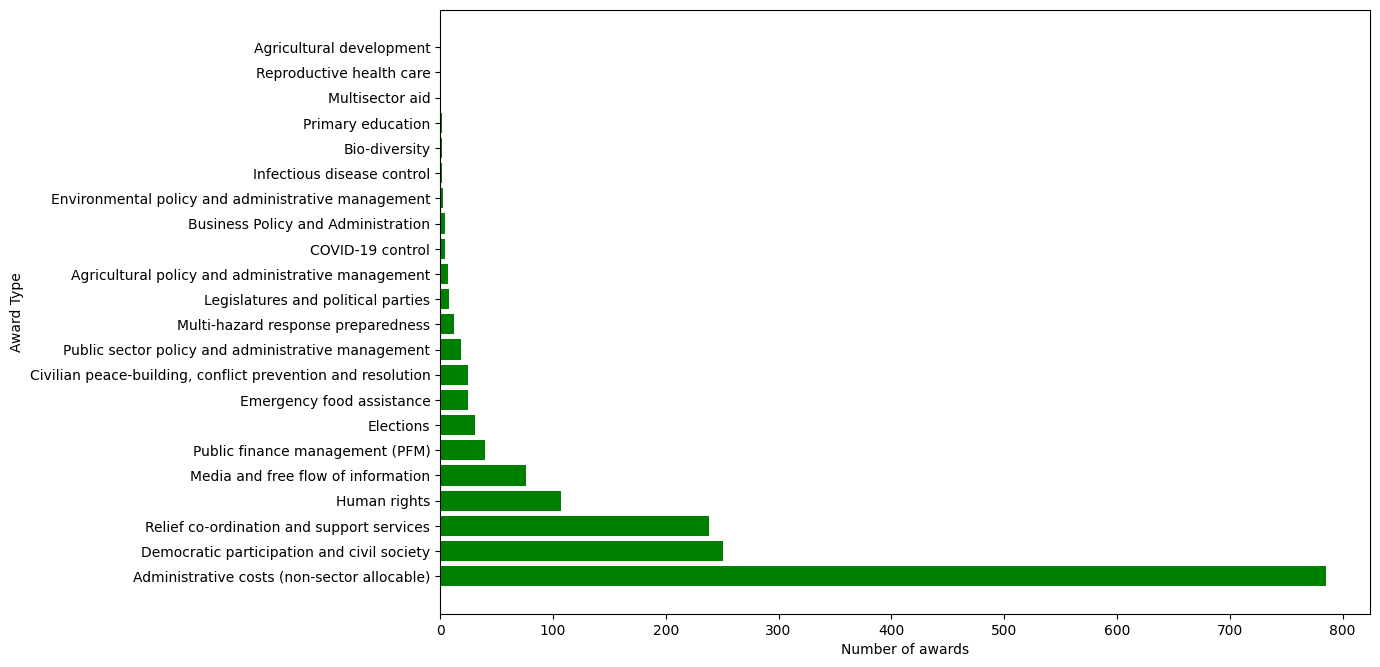

In [17]:
plt.barh(aid_count.index,aid_count,color='green')
plt.xlabel("Number of awards")
plt.ylabel("Award Type")

### Discussion Questions:

- What picture is this beginning to paint about the aid rewards? Do you see anything interesting or surprising in these plots?
- What should we focus on to help us to understand the relationship between reward type and amount? 
- What can we do to the data to produce a more informative plot?



Most grants are designated for administrative costs. This is interesting, and telling, but maybe not so interesting for understanding the more substantive categories of aid grants. I want to know how the number of aid awards correspond to the amount of money granted in aid. Because they are on different scales (counts vs. $) I will min-max normalize the data so that it is all on the same scale. 

Text(0, 0.5, 'Award Type')

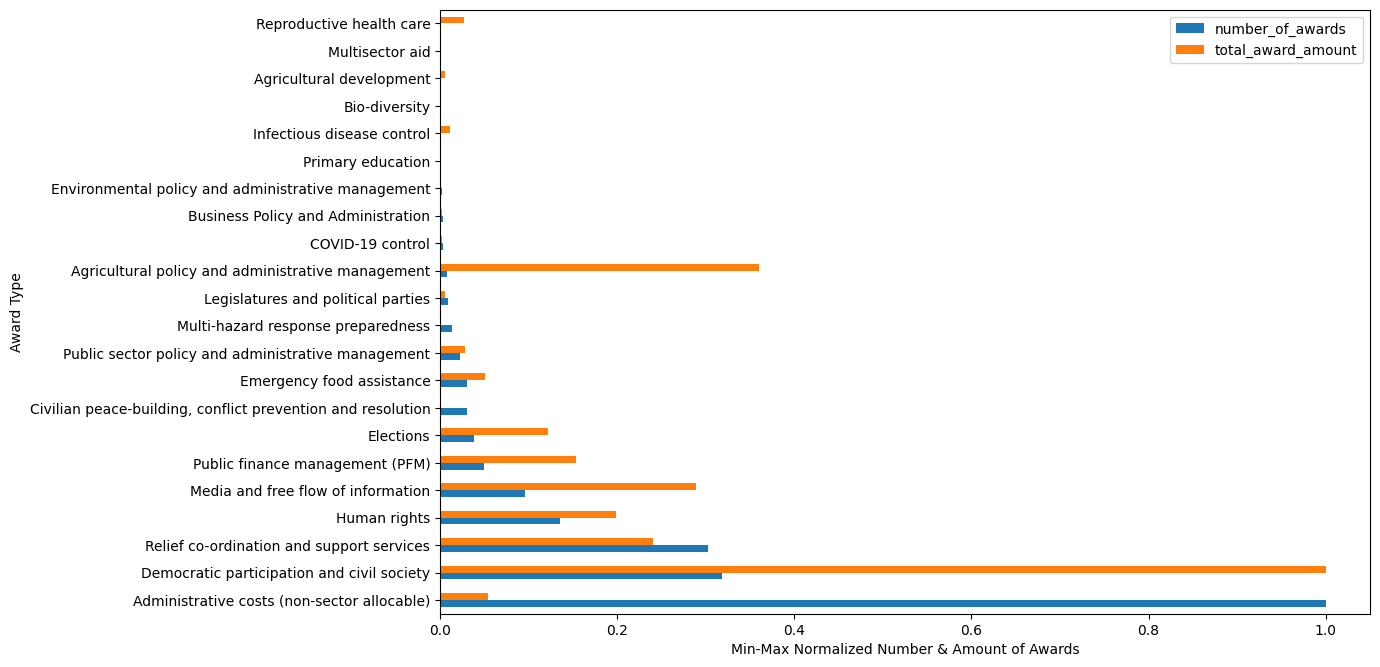

In [ ]:
aid_idx = aid_count.index
aid_amount = aid_df.groupby('Transaction - DAC Purpose Code Name')['Award - Total Estimated Value'].sum().loc[aid_idx]
amount_per_award = aid_amount/aid_count

print_df = pd.DataFrame({'number_of_awards':aid_count,
                         'total_award_amount':aid_amount},
                        index=aid_idx)

print_df['number_of_awards'] = (print_df['number_of_awards']-print_df['number_of_awards'].min())/(print_df['number_of_awards'].max()-print_df['number_of_awards'].min())
print_df['total_award_amount'] = (print_df['total_award_amount']-print_df['total_award_amount'].min())/(print_df['total_award_amount'].max()-print_df['total_award_amount'].min())

print_df.plot.barh() 
plt.xlabel("Min-Max Normalized Number & Amount of Awards")
plt.ylabel("Award Type")

###Discussion Questions:

- How do we interpret this? 
- What can we learn about these aid awards? Is this as you would expect?



We now have a very high-level view of the number and amount of aid awards. Let's next look at how these awards were administered over time. 

We first want to convert dates into a format that we can use for our analyses. Pandas has some built-in support for dates - the 'to_datetime' command forces a string representing a date into a formal date format

Note that 2009 and 2010 - we can assume that this is because there were no awards made in those years. In this case, absence is still informative, so we want to add those values back into the dataset.

In [ ]:
aid_df['Award - Start Date'] = pd.to_datetime(aid_df['Award - Start Date'], infer_datetime_format=True) 
aid_df['Award - End Date'] = pd.to_datetime(aid_df['Award - End Date'], infer_datetime_format=True) 
aid_df['start_year'] = pd.DatetimeIndex(aid_df['Award - Start Date']).year

In [ ]:
plot_counts = aid_df
keep = plot_counts['Transaction - DAC Purpose Code Name'].value_counts(ascending=False).nlargest(5).index.tolist()
plot_counts.loc[~plot_counts['Transaction - DAC Purpose Code Name'].isin(keep), 'Transaction - DAC Purpose Code Name'] = 'Other'

yearly_transaction = pd.crosstab(plot_counts['Transaction - DAC Purpose Code Name'], plot_counts['start_year']).transpose()
add_years = pd.DataFrame(index = [2009,2010], data =([0,0,0,0,0],[0,0,0,0,0]),columns=yearly_transaction.columns)
yearly_transaction = yearly_transaction.append(add_years).sort_index()
yearly_transaction

Transaction - DAC Purpose Code Name,Administrative costs (non-sector allocable),Democratic participation and civil society,Human rights,Other,Relief co-ordination and support services
2002,57,0,0,0,0
2003,1,19,0,4,0
2004,25,0,0,0,0
2005,65,0,0,0,0
2006,19,0,0,0,0
2007,21,0,0,0,0
2008,0,16,0,3,0
2009,0,0,0,0,0
2010,0,0,0,0,0
2011,0,2,0,0,0


Text(0, 0.5, 'Number of aid grants')

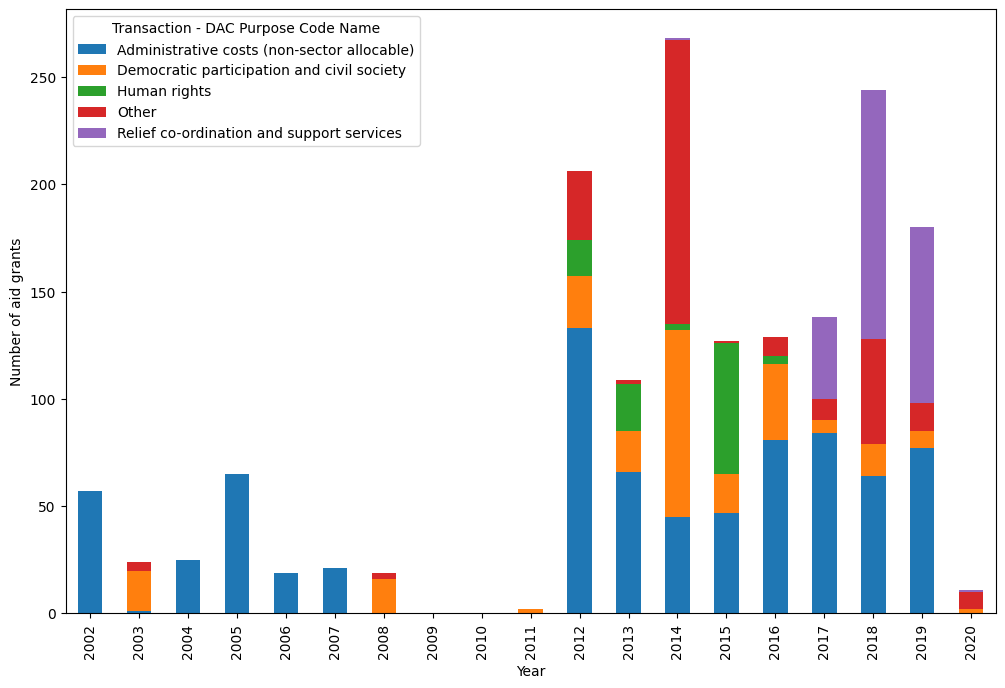

In [ ]:
ax = yearly_transaction.sort_index().plot(kind='bar',stacked=True)
ax.set_xlabel("Year")
ax.set_ylabel("Number of aid grants")

Next we are going to repeat this process for the award amounts over time.

In [ ]:
plot_amounts = aid_df
keep = plot_amounts.groupby(['Transaction - DAC Purpose Code Name'])['Award - Total Estimated Value'].sum().nlargest(5).index.tolist()
plot_amounts.loc[~plot_amounts['Transaction - DAC Purpose Code Name'].isin(keep), 'Transaction - DAC Purpose Code Name'] = 'Other'

plot_amounts = plot_amounts.groupby(['Transaction - DAC Purpose Code Name','start_year'])['Award - Total Estimated Value'].sum()
plot_amounts = plot_amounts.reset_index()
plot_amounts = plot_amounts.pivot(index='start_year',columns='Transaction - DAC Purpose Code Name',values='Award - Total Estimated Value').fillna(0)

add_years = pd.DataFrame(index = [2009,2010], data =([0,0,0,0,0],[0,0,0,0,0]),columns=plot_amounts.columns)
plot_amounts = plot_amounts.append(add_years)
plot_amounts

Transaction - DAC Purpose Code Name,Administrative costs (non-sector allocable),Democratic participation and civil society,Human rights,Other,Relief co-ordination and support services
2002,0.00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2003,5620381.89,1.067873e+08,0.000000e+00,2.248153e+07,0.000000e+00
2004,0.00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2005,0.00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2006,0.00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2007,0.00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2008,0.00,7.905000e+07,0.000000e+00,1.581000e+07,0.000000e+00
2011,0.00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2012,54460612.03,4.333048e+07,2.226465e+07,1.780461e+07,0.000000e+00
2013,0.00,4.414500e+08,4.290000e+07,1.400000e+08,0.000000e+00


Text(0, 0.5, 'Total amount of aid grants')

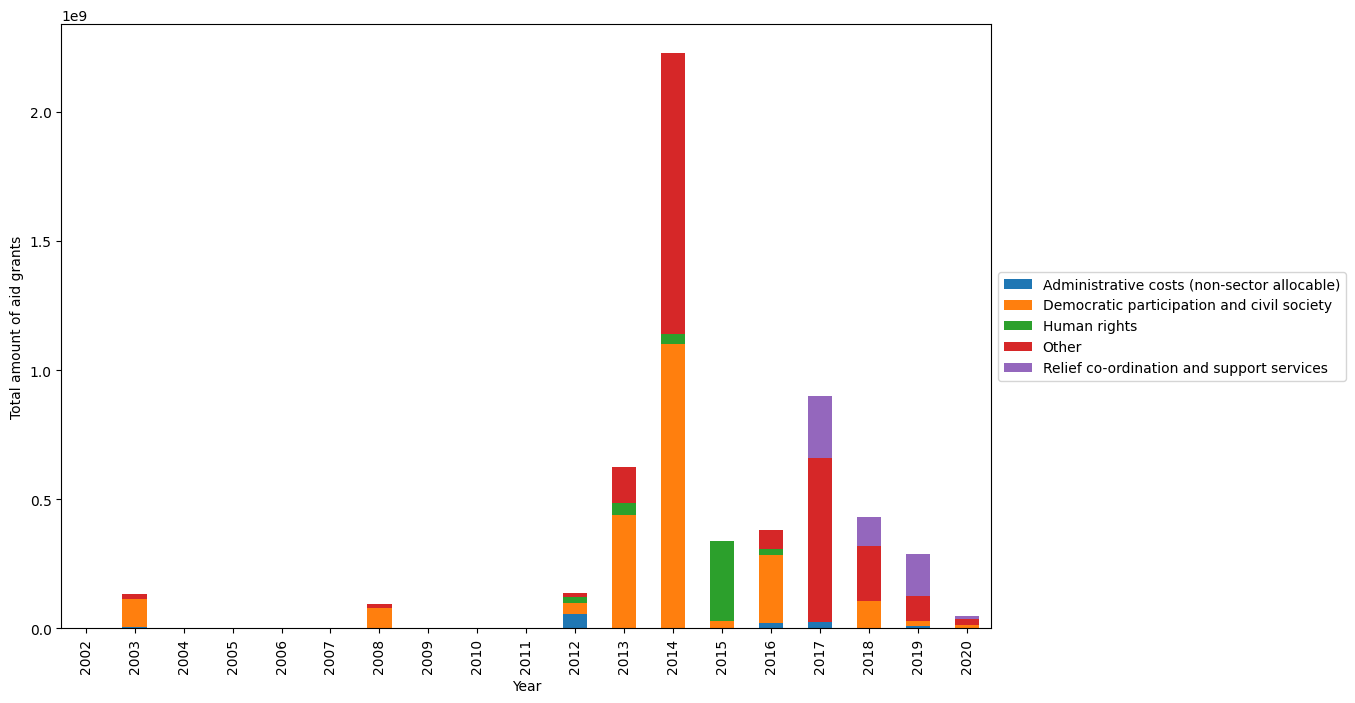

In [ ]:
ax = plot_amounts.sort_index().plot(kind='bar',stacked=True)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set_xlabel("Year")
ax.set_ylabel("Total amount of aid grants")

Text(0, 0.5, 'Number of aid grants')

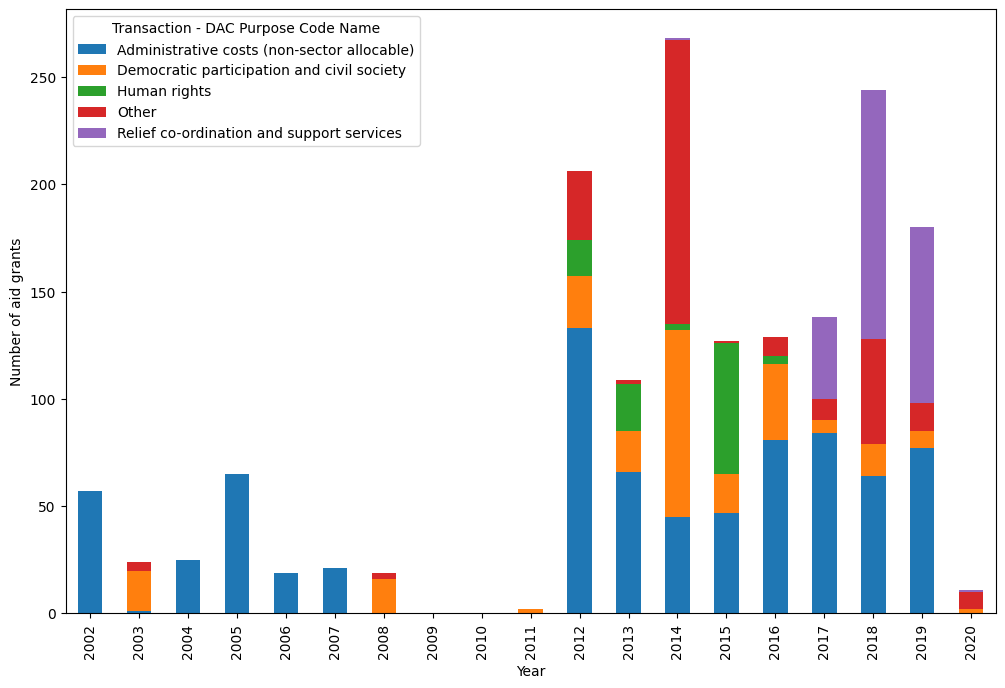

In [ ]:
ax = yearly_transaction.sort_index().plot(kind='bar',stacked=True)
ax.set_xlabel("Year")
ax.set_ylabel("Number of aid grants")

### Question to the class:

What do these plots tell us about aid awards to Venezuela?